/miniconda3/envs/tf_jupyter/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


           0      1              2     3    4    5         6    7    8   9   \
0  59.166.0.0   1390  149.171.126.6    53  udp  CON  0.001055  132  164  31   
1  59.166.0.0  33661  149.171.126.9  1024  udp  CON  0.036133  528  304  31   
2  59.166.0.6   1464  149.171.126.7    53  udp  CON  0.001119  146  178  31   

   ...  39  40  41 42  43  44  45  46   47  48  
0  ...   0   3   7  1   3   1   1   1  NaN   0  
1  ...   0   2   4  2   3   1   1   2  NaN   0  
2  ...   0  12   8  1   2   2   1   1  NaN   0  

[3 rows x 49 columns]
Read 700001 rows.
Train on 525000 samples, validate on 175001 samples
Epoch 1/1000
 - 25s - loss: 0.0043 - acc: 0.9993 - val_loss: 1.2187e-06 - val_acc: 1.0000
Epoch 2/1000
 - 23s - loss: 1.3368e-05 - acc: 1.0000 - val_loss: 1.6846e-07 - val_acc: 1.0000
Epoch 3/1000
 - 22s - loss: 1.1939e-07 - acc: 1.0000 - val_loss: 1.1926e-07 - val_acc: 1.0000
Epoch 4/1000
 - 22s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1924e-07 - val_acc: 1.0000
Epoch 5/1000
 - 21s - 

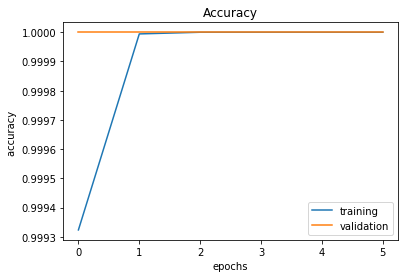

Confusion matrix, without normalization
[[169374      0]
 [     0   5627]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


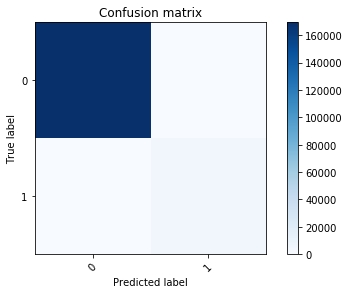

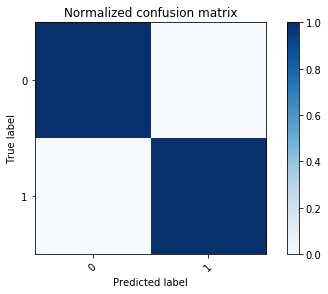

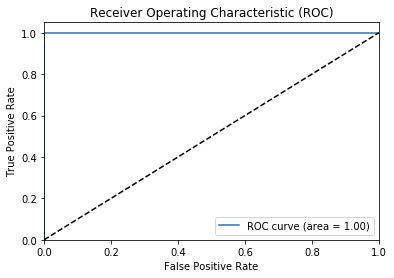

Average precision-recall score: 1.00


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=1.00')

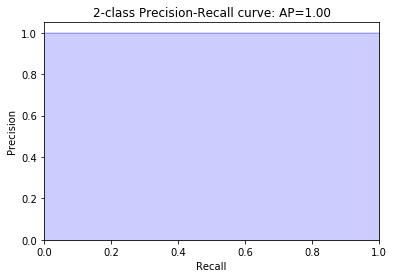

In [3]:
 import pandas as pd
import io
import requests
import numpy as np
import os
import matplotlib.pyplot as plt
import pylab as pl
import tensorflow.contrib.learn as skflow
import string


#from sklearn.utils.multiclass import unique_labels
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_curve, auc, average_precision_score, precision_recall_curve
from inspect import signature
%matplotlib inline

path = "UNSW-NB15_1.csv"
# This file is a CSV, just no CSV extension or headers
df = pd.read_csv(path, header=None)
print(df[0:3])

print("Read {} rows.".format(len(df)))
# df = df.sample(frac=0.1, replace=False) # Uncomment this line to sample only 10% of the dataset
#df.dropna(inplace=True,axis=1) # For now, just drop NA's (rows with missing values)

# The CSV file has no column heads, so add them
df.columns = [
    'srcip',
    'sport',
    'dstip',
    'dsport',
    'proto',
    'state',
    'dur',
    'sbyte',
    'dbytes',
    'sttl',
    'dttl',
    'sloss',
    'dloss',
    'service',
    'Sload',
    'Dload',
    'Spkts',
    'Dpkts',
    'swin',
    'dwin',
    'stcpb',
    'dtcpb',
    'smeansz',
    'dmeansz',
    'trans',
    'res',
    'Sjit',
    'Djit',
    'Stime', #QUITAR
    'Ltime', #QUITAR
    'Sintpkt',
    'Dintpkt',
    'tcprtt',
    'synack',
    'ackdat',
    'is_sm_ips_ports',
    'ct_state_ttl',
    'ct_flw_http_mthd',
    'is_ftp_login',
    'ct_ftp_cmd',
    'ct_srv_src',
    'ct_srv_dst',
    'ct_dst_ltm',
    'ct_src_ltm', 
    'ct_src_dport_ltm',
    'ct_dst_sport_lt', 
    'ct_dst_src_ltm',
    'attack_cat',
    'Label'
]

df.drop('sport', 1, inplace=True)#
df.drop('dsport', 1, inplace=True)#
df.drop('state', 1, inplace=True)#
df.drop('dur', 1, inplace=True)#
df.drop('Sload', 1, inplace=True)#
df.drop('Dload', 1, inplace=True)#
df.drop('Stime', 1, inplace=True)#
df.drop('Ltime', 1, inplace=True)#
df.drop('ct_src_ltm', 1, inplace=True)#

ENCODING = 'utf-8'

def expand_categories(values):
    result = []
    s = values.value_counts()
    t = float(len(values))
    for v in s.index:
        result.append("{}:{}%".format(v,round(100*(s[v]/t),2)))
    return "[{}]".format(",".join(result))
        
def analyze(filename):
    print()
    print("Analyzing: {}".format(filename))
    df = pd.read_csv(filename,encoding=ENCODING)
    cols = df.columns.values
    total = float(len(df))

    print("{} rows".format(int(total)))
    for col in cols:
        uniques = df[col].unique()
        unique_count = len(uniques)
        if unique_count>100:
            print("** {}:{} ({}%)".format(col,unique_count,int(((unique_count)/total)*100)))
        else:
            print("** {}:{}".format(col,expand_categories(df[col])))
            expand_categories(df[col])

#analyze(path)


# display 5 rows
df[0:5]

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

#Clean 'date' column and convert to Int type
def clean_date(s):
    s = ''.join([i for i in s if i not in frozenset(string.punctuation)])
    s_removed = s.replace(" ", "")
    s_int = int(s_removed)
    return s_int

########## CLEAN IP #######################
def clean_ip(s):
    s = ''.join([i for i in s if i not in frozenset(string.punctuation)])
    s_int = int(s)
    return s_int

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

#MINMAX -1 1
# Encode a column to a range between normalized_low and normalized_high.
def min_max_1(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
        * (normalized_high - normalized_low) + normalized_low

#MINMAX 0 1
def min_max_0(df, name, normalized_low=0, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
        * (normalized_high - normalized_low) + normalized_low

    
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(
        target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    # Regression
    return df[result].values.astype(np.float32), df[[target]].values.astype(np.float32)

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')




df['srcip'] = df['srcip'].apply(clean_ip)
df['dstip'] = df['dstip'].apply(clean_ip)

# Now encode the feature vector

min_max_0(df, 'srcip')#
#encode_numeric_zscore((df, 'sport')

min_max_0(df, 'dstip') #
#encode_numeric_zscore(df, 'dsport') #must be str not int ???

encode_text_dummy(df, 'proto') #
#encode_text_dummy(df, 'state')

#encode_numeric_zscore(df, 'dur')

min_max_0(df, 'sbyte') #
min_max_0(df, 'dbytes')#
min_max_0(df, 'sttl')#
min_max_0(df, 'dttl')#
min_max_0(df, 'sloss')#
min_max_0(df, 'dloss')#
encode_text_dummy(df, 'service') #
#encode_numeric_zscore(df, 'Sload')

#encode_numeric_zscore(df, 'Dload')

min_max_0(df, 'Spkts')#
min_max_0(df, 'Dpkts')#
min_max_0(df, 'swin')#
min_max_0(df, 'dwin')#
min_max_0(df, 'stcpb')#
min_max_0(df, 'dtcpb')#
min_max_0(df, 'smeansz')#
min_max_0(df, 'dmeansz')#
min_max_0(df, 'trans')#
min_max_0(df, 'res')#
min_max_0(df, 'Sjit')#
min_max_0(df, 'Djit')#

min_max_0(df, 'Sintpkt')#
min_max_0(df, 'Dintpkt')#
min_max_0(df, 'tcprtt')#
min_max_0(df, 'synack')#
min_max_0(df, 'ackdat')#
#encode_numeric_zscore(df, 'is_sm_ips_ports')#
min_max_0(df, 'ct_state_ttl')#
min_max_0(df, 'ct_flw_http_mthd')#
#encode_numeric_zscore(df, 'is_ftp_login')#
min_max_0(df, 'ct_ftp_cmd')#
min_max_0(df, 'ct_srv_src')#
min_max_0(df, 'ct_srv_dst')#
min_max_0(df, 'ct_dst_ltm')#
#encode_numeric_zscore(df, 'ct_src_ltm')

min_max_0(df, 'ct_src_dport_ltm')#
min_max_0(df, 'ct_dst_sport_lt')#
min_max_0(df, 'ct_dst_src_ltm')#
#encode_numeric_zscore(df, 'attack_cat')#
encode_text_dummy(df, 'attack_cat')

outcomes = encode_text_index(df, 'Label')#
num_classes = len(outcomes)

# display 5 rows

df.dropna(inplace=True,axis=1)
df[0:5]


##################################################
# Break into X (predictors) & y (prediction)
x, y = to_xy(df,'Label')
#################################################



# Create a test/train split.  25% test
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42)

# Create neural net
model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(50, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.add(Dense(y.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)


# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_eval = np.argmax(y_test,axis=1)
score = metrics.accuracy_score(y_eval, pred)
print("Validation score: {}".format(score))

print(outcomes)

### PLOT ACCURACY ####

plt.plot(np.arange(len(history.history['acc'])),
history.history['acc'], label='training')
plt.plot(np.arange(len(history.history['val_acc'])),
history.history['val_acc'], label='validation')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy ')
plt.legend(loc=0)
plt.show()

### PLOT CONFUSION MATRIX ###

# Not normalized
cm = confusion_matrix(y_eval, pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, outcomes)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, outcomes, title='Normalized confusion matrix')

plt.show()


### PLOT ROC ###

#Plot an ROC. pred - the predictions, y - the expected outpus.
#En mi caso creo que es pred == pred y== y_eval
def plot_roc(pred, y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr,tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

plot_roc(pred, y_eval)


### PRECISION-RECALL ###

average_precision = average_precision_score(y_eval, pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))



precision, recall, _ = precision_recall_curve(y_eval, pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))